C:\Users\pparvizi24\AppData\Local\Temp\ipykernel_14328\875152490.py:519: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


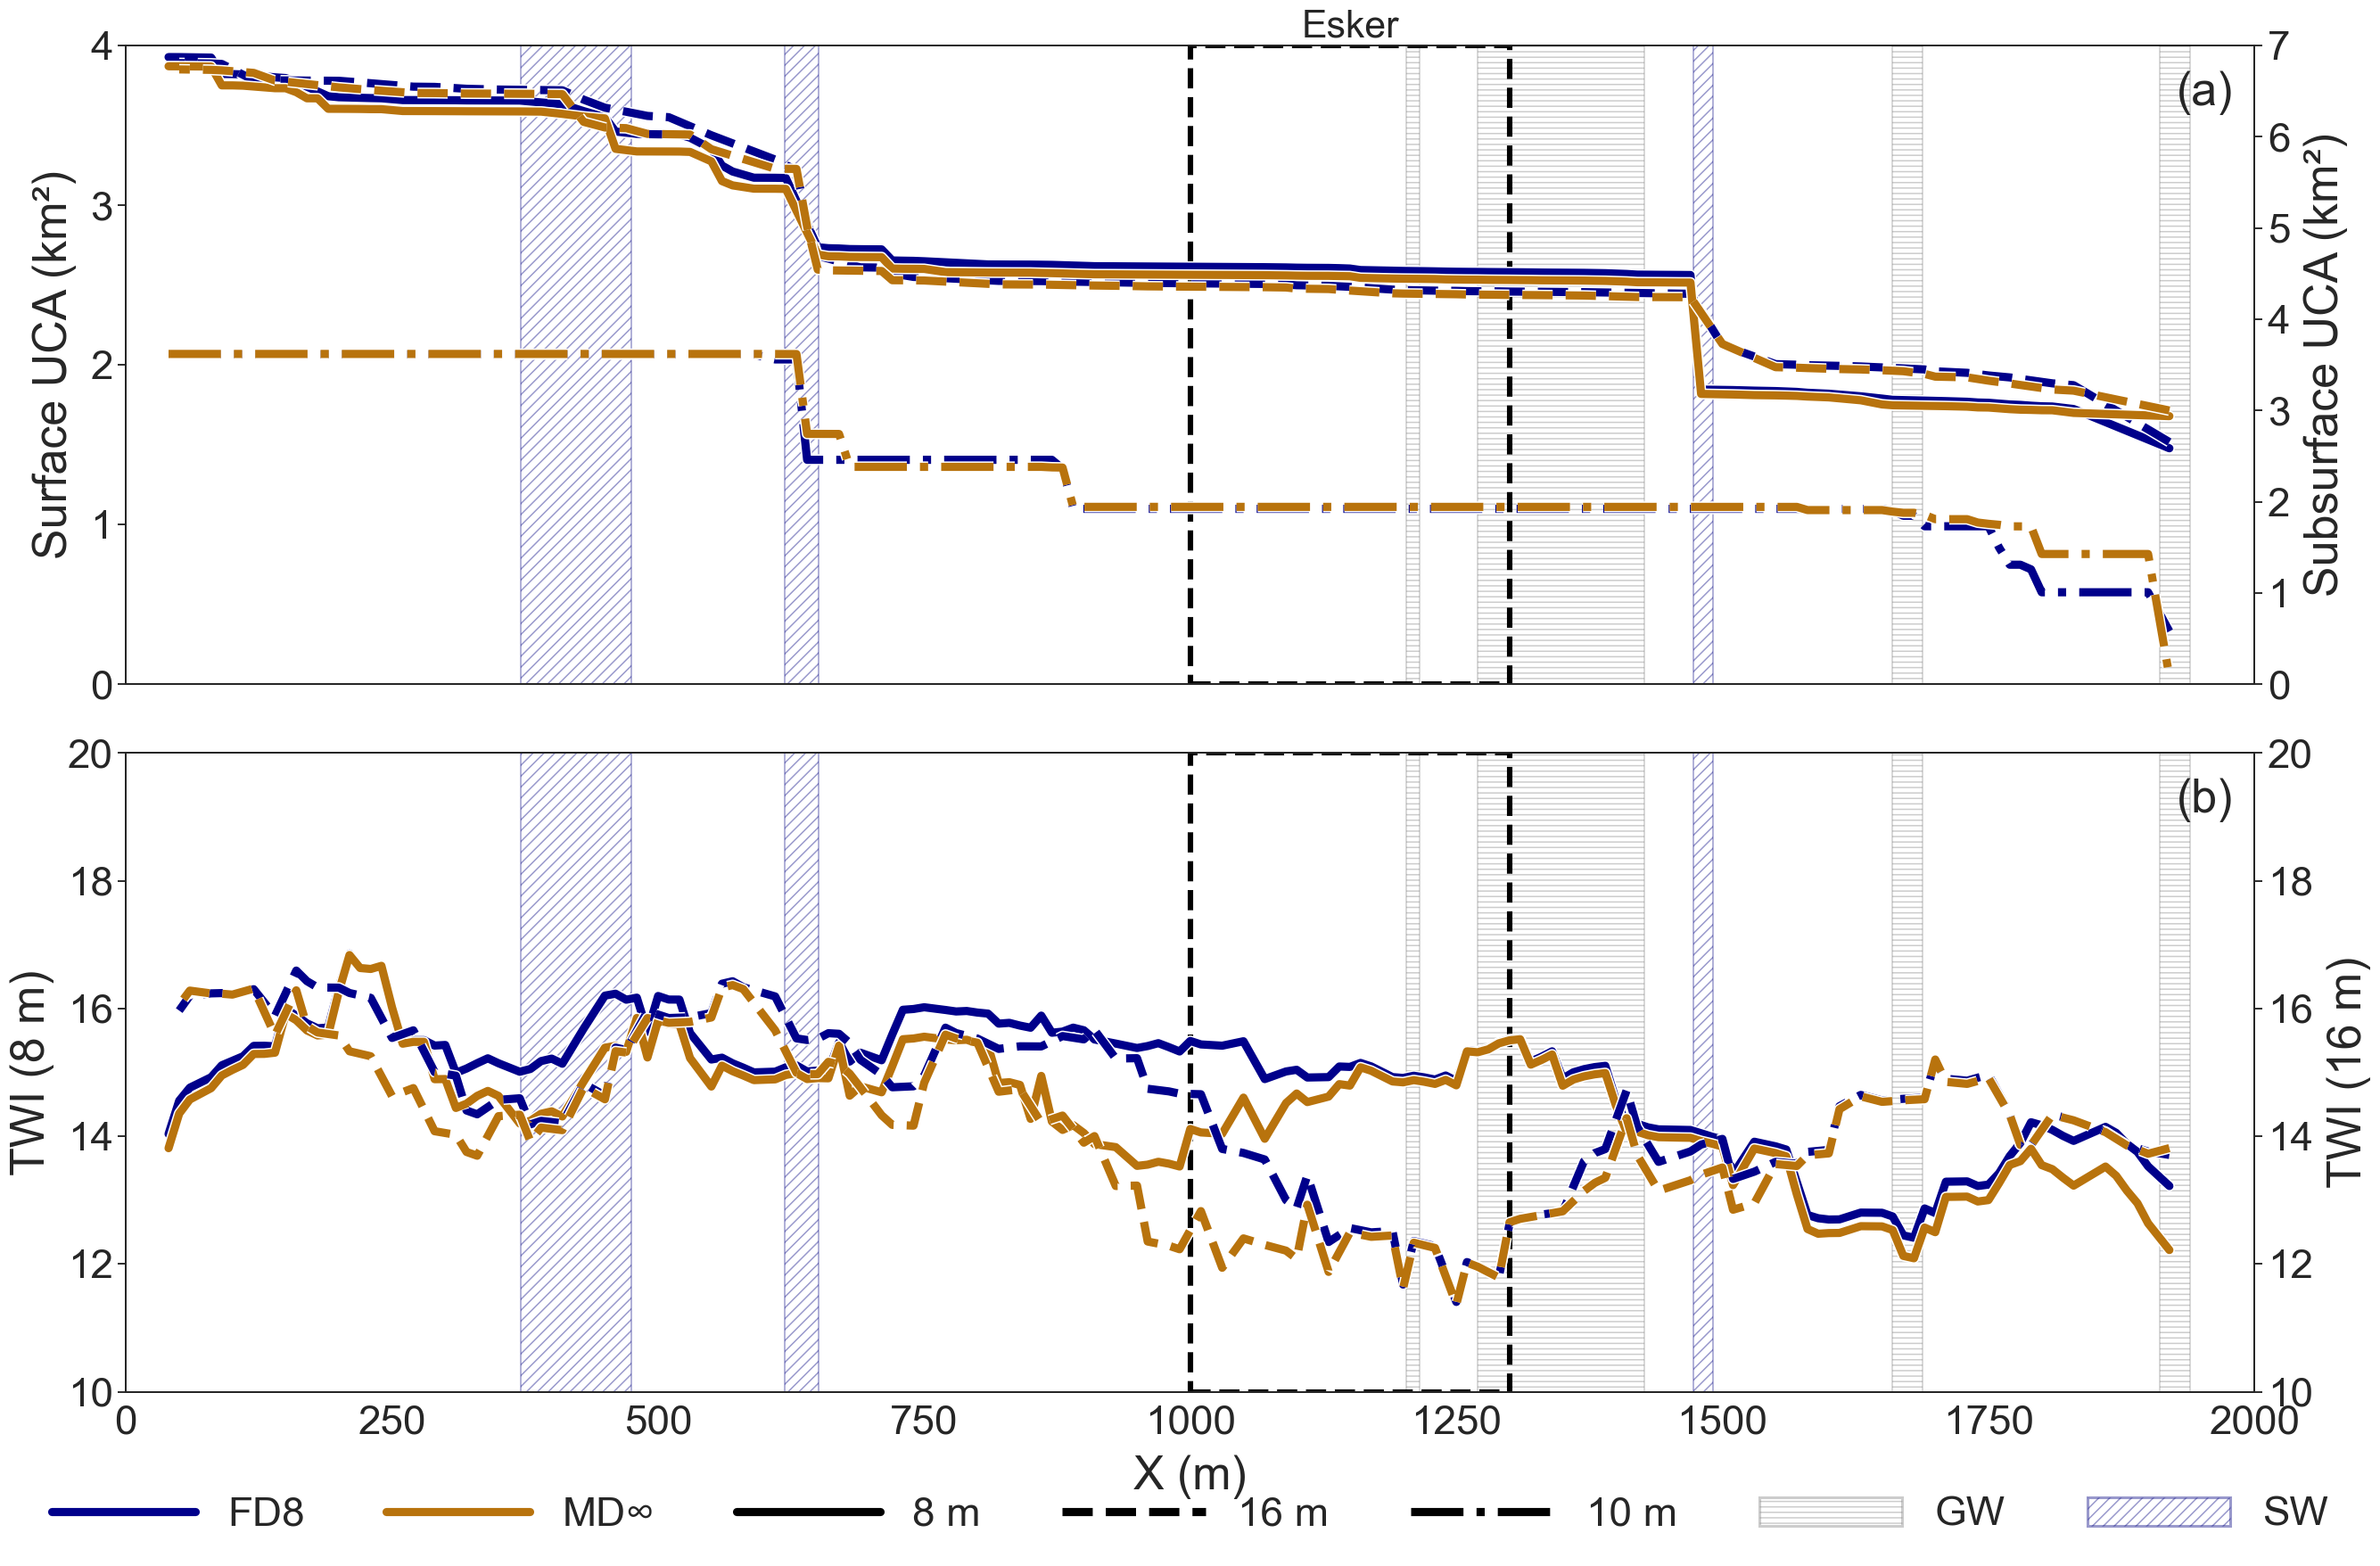

In [ ]:
# Imports

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl

import seaborn as sns
import rasterio


# Global matplotlib style
# This block guarantees consistent large fonts across notebooks and twin axes

mpl.rcParams.update(mpl.rcParamsDefault)

mpl.rcParams.update({
    "font.family": "Arial",

    "font.size": 30,
    "axes.labelsize": 34,
    "axes.titlesize": 36,

    "xtick.labelsize": 30,
    "ytick.labelsize": 30,

    "legend.fontsize": 30,

    "axes.linewidth": 2.5,
    "xtick.major.width": 2.5,
    "ytick.major.width": 2.5,
    "xtick.major.size": 10,
    "ytick.major.size": 10,

    "figure.dpi": 110,
    "savefig.dpi": 300,
})


# ============================================================
# DATA PATHS - Update these paths for your local system
# ============================================================

# Input paths
BASE_WBT_DIR = "./data/WBT_data"

SURFACE_FLOW_ACCUMULATION_CSV = "./data/WBT_data/flow_accumulation_cleaned_data.csv"

BEDROCK_UCA_DIR = "./data/WBT_data/br_elev_20250715_out/flowacc_out/uca_profiles"

GW_INFLOW_CSV = "./GW_inflow_locations.csv"

# GW/SW hatched zones (exported from DTS GW & SW Classifications.ipynb)
GW_SLOPE_CSV = "./GW_inflow_locations_slope.csv"
SW_SLOPE_CSV = "./SW_inflow_locations_slope.csv"


# Load TWI profiles

def load_twi_data_for_dual_axis():
    
    resolutions = [8, 16]
    methods = ['d8', 'dinf', 'fd8', 'mdinf', 'rho8']

    twi_method_colors = {
        'd8': '#5a1a35',
        'dinf': '#4a2bb8',
        'fd8': 'darkblue',
        'mdinf': '#b8730d',
        'rho8': '#0f2d3f'
    }

    resolution_styles = {8: '-', 16: '--'}

    def load_single(method, resolution):

        csv_path = os.path.join(
            BASE_WBT_DIR,
            f"pallas_{resolution}",
            f"twi_1d_{method}_clipped.csv"
        )

        if not os.path.exists(csv_path):
            return None

        df = pd.read_csv(csv_path, index_col=0)
        if df.empty:
            return None

        if 'twi_smooth' in df.columns:
            values = df['twi_smooth']
        elif 'twi_value' in df.columns:
            values = df['twi_value']
        else:
            return None

        out = pd.DataFrame({'twi_value': values})
        out.index.name = 'stream_length'
        return out

    all_data = {}

    for method in methods:
        for res in resolutions:
            df = load_single(method, res)
            if df is not None:
                all_data[f"{res}m_{method}"] = df

    return all_data, twi_method_colors, resolution_styles


# Load surface flow accumulation profiles

def load_flow_accumulation_for_dual_axis():

    resolutions = [8, 16]
    methods = ['d8', 'dinf', 'fd8', 'mdinf', 'rho8']

    flow_method_colors = {
        'd8': '#5a1a35',
        'dinf': '#4a2bb8',
        'fd8': 'darkblue',
        'mdinf': '#b8730d',
        'rho8': '#0f2d3f'
    }

    resolution_styles = {8: '-', 16: '--'}

    def extract_profile(method, resolution):

        flow_tif = os.path.join(
            BASE_WBT_DIR,
            f"pallas_{resolution}",
            f"korkeusmalli_{resolution}m_culverts_water_no_deps_flowacc_{method}_clipped.tif"
        )

        stream_tif = os.path.join(
            BASE_WBT_DIR,
            f"pallas_{resolution}",
            "stream_lengths_burned_clipped.tif"
        )

        if not os.path.exists(flow_tif) or not os.path.exists(stream_tif):
            return None

        with rasterio.open(flow_tif) as src:
            flow_acc = src.read(1)

        with rasterio.open(stream_tif) as src:
            stream_len = src.read(1).astype(float)

        stream_len[stream_len == 0] = np.nan
        unique_lengths = np.unique(stream_len)
        unique_lengths = unique_lengths[np.isfinite(unique_lengths)]

        data = []
        pixel_area = resolution * resolution

        for length in unique_lengths:
            sca = flow_acc[stream_len == length][0]
            upslope_km2 = (sca * resolution) / 1e6
            data.append({'stream_length': length, 'upslope_area_km2': upslope_km2})

        df = pd.DataFrame(data).sort_values('stream_length', ascending=False)
        df = df[df['upslope_area_km2'].cummax() == df['upslope_area_km2']]
        df.set_index('stream_length', inplace=True)

        return df

    all_data = {}

    for method in methods:
        for res in resolutions:
            df = extract_profile(method, res)
            if df is not None:
                all_data[f"{res}m_{method}"] = df

    return all_data, flow_method_colors, resolution_styles


# Load bedrock UCA profiles

def load_bedrock_profiles(bedrock_dir):

    methods = ['d8', 'fd8', 'rho8', 'dinf', 'mdinf']
    profiles = {}

    for method in methods:
        csv_path = Path(bedrock_dir) / f"uca_profile_{method}.csv"
        if csv_path.exists():
            profiles[method] = pd.read_csv(csv_path)

    return profiles


# Main plotting function
# Dual Y-axis preserved in both panels and legend unchanged

def plot_ucas_and_twi_single_panel(
    surface_flow_data,
    bedrock_flow_profiles,
    twi_data,
    twi_method_colors,
    twi_resolution_styles,
    method_colors,
    resolution_styles,
    surface_flow_acc_ylim,
    bedrock_flow_acc_ylim,
    twi_8m_ylim,
    twi_16m_ylim,
    gw_inflow_path=None,
    figsize=(28, 20),
    show=True
):

    sns.set_theme(style="white")

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 2, 0.3], hspace=0.15)

    ax_uca = fig.add_subplot(gs[0, 0])
    ax_twi = fig.add_subplot(gs[1, 0])
    ax_leg = fig.add_subplot(gs[2, 0])
    ax_leg.axis("off")

    # Optional: legacy light-grey GW shading (kept for backwards compatibility)
    if gw_inflow_path and os.path.exists(gw_inflow_path):
        gw_df = pd.read_csv(gw_inflow_path)
        if {"start_m", "end_m"}.issubset(gw_df.columns):
            for ax in [ax_uca, ax_twi]:
                for s, e in zip(gw_df["start_m"], gw_df["end_m"]):
                    ax.axvspan(s, e, color="lightgrey", alpha=0.45, zorder=0)

    surface_methods = set()
    surface_resolutions = set()

    for key, df in surface_flow_data.items():
        res = int(key.split("m_")[0])
        method = key.split("m_")[1]

        if method in ["fd8", "mdinf"]:
            ax_uca.plot(
                df.index,
                df["upslope_area_km2"],
                color=method_colors[method],
                linestyle=resolution_styles[res],
                linewidth=6,
                path_effects=[pe.Stroke(linewidth=8, foreground="white"), pe.Normal()],
            )
            surface_methods.add(method)
            surface_resolutions.add(res)

    ax_uca.set_ylabel("Surface UCA (km²)", fontsize=34, labelpad=10)
    ax_uca.set_ylim(surface_flow_acc_ylim)
    ax_uca.set_xlim(0, 2000)
    ax_uca.set_xticklabels([])
    ax_uca.tick_params(axis='y', labelsize=30)

    ax_bed = ax_uca.twinx()
    bedrock_methods = set()

    for method, df in bedrock_flow_profiles.items():
        if method in ["fd8", "mdinf"]:
            ax_bed.plot(
                df["distance_m"],
                df["UCA_km2"],
                linestyle="-.",
                color=method_colors[method],
                linewidth=6,
                path_effects=[pe.Stroke(linewidth=8, foreground="white"), pe.Normal()],
            )
            bedrock_methods.add(method)

    ax_bed.set_ylabel("Subsurface UCA (km²)", fontsize=34, labelpad=10)
    ax_bed.set_ylim(bedrock_flow_acc_ylim)
    ax_bed.tick_params(axis='y', labelsize=30)

    twi_8m_methods = set()

    for key, df in twi_data.items():
        res = int(key.split("m_")[0])
        method = key.split("m_")[1]

        if res == 8 and method in ["fd8", "mdinf"]:
            ax_twi.plot(
                df.index,
                df["twi_value"],
                color=twi_method_colors[method],
                linestyle=twi_resolution_styles[8],
                linewidth=6,
                path_effects=[pe.Stroke(linewidth=8, foreground="white"), pe.Normal()],
            )
            twi_8m_methods.add(method)

    ax_twi.set_ylabel("TWI (8 m)", fontsize=34, labelpad=10)
    ax_twi.set_xlabel("X (m)", fontsize=34, labelpad=10)
    ax_twi.set_ylim(twi_8m_ylim)
    ax_twi.set_xlim(0, 2000)
    ax_twi.tick_params(axis='both', labelsize=30)

    ax_twi_16 = ax_twi.twinx()
    twi_16m_methods = set()

    for key, df in twi_data.items():
        res = int(key.split("m_")[0])
        method = key.split("m_")[1]

        if res == 16 and method in ["fd8", "mdinf"]:
            ax_twi_16.plot(
                df.index,
                df["twi_value"],
                color=twi_method_colors[method],
                linestyle=twi_resolution_styles[16],
                linewidth=6,
                path_effects=[pe.Stroke(linewidth=8, foreground="white"), pe.Normal()],
            )
            twi_16m_methods.add(method)

    ax_twi_16.set_ylabel("TWI (16 m)", fontsize=34, labelpad=10)
    ax_twi_16.set_ylim(twi_16m_ylim)
    ax_twi_16.tick_params(axis='y', labelsize=30)

    def format_method(m):
        return {"fd8": "FD8", "mdinf": "MD∞"}.get(m, m.upper())

    method_handles = [
        Line2D([0], [0], color=method_colors[m], linewidth=6, label=format_method(m))
        for m in ["fd8", "mdinf"]
        if m in (surface_methods | bedrock_methods | twi_8m_methods | twi_16m_methods)
    ]

    resolution_handles = []

    if 8 in surface_resolutions or twi_8m_methods:
        resolution_handles.append(Line2D([0], [0], color="black", linestyle="-", linewidth=6, label="8 m"))
    if 16 in surface_resolutions or twi_16m_methods:
        resolution_handles.append(Line2D([0], [0], color="black", linestyle="--", linewidth=6, label="16 m"))
    if bedrock_methods:
        resolution_handles.append(Line2D([0], [0], color="black", linestyle="-.", linewidth=6, label="10 m"))

    # Add GW and SW legend entries
    gw_patch = Rectangle((0, 0), 1, 1, facecolor="none", edgecolor="grey", hatch="---", alpha=0.4, linewidth=2, label="GW")
    sw_patch = Rectangle((0, 0), 1, 1, facecolor="none", edgecolor="navy", hatch="///", alpha=0.4, linewidth=2, label="SW")
    
    handles = method_handles + resolution_handles + [gw_patch, sw_patch]

    ax_leg.legend(
        handles,
        [h.get_label() for h in handles],
        ncol=7,
        loc="upper center",
        frameon=False,
        handlelength=3.5,
        fontsize=30,
        prop={"family": "Arial", "size": 30},
    )

    if show:
        plt.show()

    return fig, (ax_uca, ax_twi)


# Load data

twi_data, twi_method_colors, twi_resolution_styles = load_twi_data_for_dual_axis()
surface_flow_data, _, _ = load_flow_accumulation_for_dual_axis()
bedrock_profiles = load_bedrock_profiles(BEDROCK_UCA_DIR)


# Color and style definitions

method_colors = {
    "d8": "#5a1a35",
    "fd8": "darkblue",
    "rho8": "#0f2d3f",
    "dinf": "#4a2bb8",
    "mdinf": "#b8730d",
}

resolution_styles = {
    8: "-",
    16: "--",
}


# Create the figure

fig, ax = plot_ucas_and_twi_single_panel(
    surface_flow_data=surface_flow_data,
    bedrock_flow_profiles=bedrock_profiles,
    twi_data=twi_data,
    twi_method_colors=twi_method_colors,
    twi_resolution_styles=twi_resolution_styles,
    method_colors=method_colors,
    resolution_styles=resolution_styles,
    surface_flow_acc_ylim=(0, 4),
    bedrock_flow_acc_ylim=(0, 7),
    twi_8m_ylim=(10, 20),
    twi_16m_ylim=(10, 20),
    # Disable solid background shading; we overlay hatched GW/SW zones below instead.
    gw_inflow_path=None,
    show=False,
)


# --- GW/SW hatched zones + Esker overlay (same style as your 3-panel figure) ---

def _segments_from_df(df: pd.DataFrame):
    if {"x_start_m", "x_end_m"}.issubset(df.columns):
        return list(zip(df["x_start_m"].values, df["x_end_m"].values))
    if {"start_m", "end_m"}.issubset(df.columns):
        return list(zip(df["start_m"].values, df["end_m"].values))
    raise ValueError(
        "Could not find segment columns. Expected x_start_m/x_end_m or start_m/end_m. "
        f"Found: {list(df.columns)}"
    )


gw_segments_hatch = _segments_from_df(pd.read_csv(GW_SLOPE_CSV))
sw_segments_hatch = _segments_from_df(pd.read_csv(SW_SLOPE_CSV))


def _axes_with_shared_x(ax):
    # Includes twinx() axes, so the hatch appears there too.
    try:
        return list(ax.get_shared_x_axes().get_siblings(ax))
    except Exception:
        return [ax]


def _add_hatched_segments(ax, segments, *, edgecolor, hatch, alpha=0.4):
    """Add hatched background segments to axis."""
    for s, e in segments:
        ax.axvspan(s, e, facecolor="none", edgecolor=edgecolor, hatch=hatch, alpha=alpha, zorder=0)


def _add_esker(ax, *, start=1000, end=1300):
    """Add esker zone with dashed black border."""
    ax.axvspan(start, end, facecolor="none", edgecolor="black", linestyle="--", linewidth=4, zorder=1)


ax_uca, ax_twi = ax
for base_ax in [ax_uca, ax_twi]:
    siblings = _axes_with_shared_x(base_ax)

    # Make any twinned/overlaid axes transparent so base hatch shows through
    for a in siblings:
        if a is not base_ax:
            try:
                a.patch.set_alpha(0)
            except Exception:
                pass

    # Draw hatch + esker on the base axis only
    _add_hatched_segments(base_ax, gw_segments_hatch, edgecolor="grey", hatch="---", alpha=0.4)
    _add_hatched_segments(base_ax, sw_segments_hatch, edgecolor="navy", hatch="///", alpha=0.4)
    _add_esker(base_ax, start=1000, end=1300)


# Optional: label the esker
esker_start = 1000
esker_end = 1300
ax_uca.text(
    0.5 * (esker_start + esker_end),
    ax_uca.get_ylim()[1],
    "Esker",
    ha="center",
    va="bottom",
    fontsize=28,
    rotation=0
)


# Panel labels (match style used in the 3-panel cell below)
panel_axes = [ax_uca, ax_twi]
panel_labels = ['(a)', '(b)']

for ax_i, label in zip(panel_axes, panel_labels):
    # Remove existing panel labels to avoid duplicates on re-run
    for t in list(ax_i.texts):
        txt = (t.get_text() or "").strip()
        if txt.startswith('(a)') or txt.startswith('(b)'):
            try:
                t.remove()
            except Exception:
                pass

    ax_i.text(
        0.99, 0.96,
        label,
        transform=ax_i.transAxes,
        ha='right', va='top',
        fontfamily='Arial',
        fontsize=34,
        zorder=10,
    )


plt.tight_layout()
plt.show()


In [7]:
# ============================================================================
# PLOTTING FUNCTION FOR ALL METHODS (THREE PANELS)
# ============================================================================

def plot_ucas_and_twi_all_methods_three_panels(
        surface_flow_data=None, bedrock_flow_profiles=None,
        twi_data=None, twi_method_colors=None, twi_resolution_styles=None,
        method_colors=None, resolution_styles=None,
        surface_flow_acc_ylim=None, bedrock_flow_acc_ylim=None,
        twi_8m_ylim=None, twi_16m_ylim=None,
        surface_flow_accumulation_path=None,
        gw_inflow_path='GW inflow locations.csv',
        figsize=(32, 30),
        subplot_margins=None, show=True):
    """Three-panel figure with all methods:
    
    Panel 1: Surface & Subsurface UCAs (all methods) on dual y-axis
    Panel 2: TWI 8m DEM (all methods)
    Panel 3: TWI 16m DEM (all methods)
    All panels include GW inflow background shading.
    """
    
    # Import TWI loading function if needed
    if twi_data is None or twi_method_colors is None or twi_resolution_styles is None:
        twi_data_loaded, twi_method_colors_loaded, twi_resolution_styles_loaded = load_twi_data_for_dual_axis()
        if twi_data is None:
            twi_data = twi_data_loaded
        if twi_method_colors is None:
            twi_method_colors = twi_method_colors_loaded
        if twi_resolution_styles is None:
            twi_resolution_styles = twi_resolution_styles_loaded

    if surface_flow_acc_ylim is None:
        surface_flow_acc_ylim = (0, 5)
    if bedrock_flow_acc_ylim is None:
        bedrock_flow_acc_ylim = (0, 5.6)
    if twi_8m_ylim is None:
        twi_8m_ylim = (10, 20)
    if twi_16m_ylim is None:
        twi_16m_ylim = (10, 20)

    sns.set_theme(style="white")

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(
        4, 1,
        figure=fig,
        height_ratios=[2.5, 2.5, 2.5, 0.4],
        hspace=0.18,
    )
    margins = {'left': 0.06, 'right': 0.92, 'bottom': 0.12, 'top': 0.95}
    if subplot_margins:
        margins.update(subplot_margins)
    fig.subplots_adjust(**margins)
    
    # Panel 1: UCA all methods
    ax_uca = fig.add_subplot(gs[0, 0])
    # Panel 2: TWI 8m all methods
    ax_twi_8m = fig.add_subplot(gs[1, 0])
    # Panel 3: TWI 16m all methods
    ax_twi_16m = fig.add_subplot(gs[2, 0])
    # Legend axis
    legend_ax = fig.add_subplot(gs[3, 0])
    legend_ax.axis('off')

    # GW inflow shading for all panels
    try:
        gw_df = pd.read_csv(gw_inflow_path)
        gw_segments = list(zip(gw_df["start_m"].values, gw_df["end_m"].values))
        for ax in [ax_uca, ax_twi_8m, ax_twi_16m]:
            for s, e in gw_segments:
                ax.axvspan(s, e, color='lightgrey', alpha=0.45, zorder=0)
    except Exception as e:
        print(f"Warning: Could not load GW inflow locations from {gw_inflow_path}: {e}")

    # Use the same UCA color conventions
    bedrock_method_colors = {
        'd8': '#5a1a35',
        'dinf': '#4a2bb8',
        'fd8': 'darkblue',
        'mdinf': '#b8730d',
        'rho8': '#0f2d3f',
    }
    DEFAULT_SURFACE_METHOD_COLORS = {
        'd8': '#5a1a35',
        'fd8': 'darkblue',
        'rho8': '#0f2d3f',
        'dinf': '#4a2bb8',
        'mdinf': '#b8730d',
    }
    DEFAULT_SURFACE_RESOLUTION_STYLES = {8: '-', 16: '--'}

    if surface_flow_data is None and surface_flow_accumulation_path:
        surface_flow_data = load_surface_flow_accumulation_profiles(surface_flow_accumulation_path)

    # ===== PANEL 1: Surface & Subsurface UCAs (all methods) =====
    
    # --- Surface UCA on left axis ---
    surface_plotted_methods = set()
    surface_plotted_resolutions = set()
    if surface_flow_data:
        if method_colors is None:
            method_colors = DEFAULT_SURFACE_METHOD_COLORS
        if resolution_styles is None:
            resolution_styles = DEFAULT_SURFACE_RESOLUTION_STYLES
        if method_colors and resolution_styles:
            for key, df in surface_flow_data.items():
                if len(df) > 0:
                    resolution = int(key.split('m_')[0])
                    method = key.split('m_')[1]
                    # Plot all methods for 8m and 16m DEM
                    if method in method_colors and resolution in [8, 16] and resolution in resolution_styles:
                        ax_uca.plot(
                            df.index,
                            df['upslope_area_km2'],
                            linestyle=resolution_styles[resolution],
                            color=method_colors[method],
                            linewidth=6,
                            alpha=0.95,
                            zorder=4,
                            solid_capstyle='round',
                            path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()],
                        )
                        surface_plotted_methods.add(method)
                        surface_plotted_resolutions.add(resolution)

    ax_uca.set_ylabel('Surface UCA (km²)', fontsize=34, fontfamily='Arial', rotation=90, labelpad=8)
    ax_uca.set_xlim(0, 2000)
    ax_uca.set_xticks(np.arange(0, 2000 + 1, 250))
    ax_uca.set_ylim(surface_flow_acc_ylim)
    try:
        y0, y1 = surface_flow_acc_ylim
        if y1 - y0 <= 10:
            ax_uca.set_yticks(np.arange(np.floor(y0), np.ceil(y1) + 1, 1))
    except Exception:
        pass
    ax_uca.tick_params(axis='x', labelsize=34, length=10, width=2)
    ax_uca.tick_params(axis='y', labelsize=34, length=10, width=2)
    ax_uca.spines['left'].set_linewidth(2.5)
    ax_uca.grid(False)
    for label in ax_uca.get_xticklabels():
        label.set_fontfamily('Arial')
        label.set_fontsize(34)
    for label in ax_uca.get_yticklabels():
        label.set_fontfamily('Arial')
        label.set_fontsize(34)
    ax_uca.yaxis.set_ticks_position('left')
    ax_uca.tick_params(axis='y', which='both', labelleft=True, pad=6)
    ax_uca.set_xticklabels([])

    # --- Subsurface UCA on right axis ---
    bedrock_plotted_methods = set()
    ax_bedrock = None
    if bedrock_flow_profiles:
        ax_bedrock = ax_uca.twinx()
        bedrock_linestyle = '-.'
        bedrock_colors_to_use = method_colors if method_colors else bedrock_method_colors

        for method, df in bedrock_flow_profiles.items():
            # Plot all methods for subsurface (bedrock)
            if method in bedrock_colors_to_use:
                ax_bedrock.plot(
                    df['distance_m'],
                    df['UCA_km2'],
                    color=bedrock_colors_to_use[method],
                    linestyle=bedrock_linestyle,
                    linewidth=6,
                    alpha=0.95,
                    zorder=4,
                    solid_capstyle='round',
                    path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()],
                )
                bedrock_plotted_methods.add(method)

        ax_bedrock.autoscale(False, axis='y')
        ax_bedrock.set_ylim(bedrock_flow_acc_ylim)
        try:
            y0, y1 = bedrock_flow_acc_ylim
            if y1 - y0 <= 10:
                ax_bedrock.set_yticks(np.arange(np.floor(y0), np.ceil(y1) + 1, 1))
        except Exception:
            pass
        ax_bedrock.set_ylabel(
            'Subsurface UCA (km²)',
            fontsize=34,
            fontfamily='Arial',
            color='black',
            rotation=90,
            labelpad=8,
        )
        ax_bedrock.tick_params(axis='y', labelsize=34, length=10, width=2, colors='black')
        ax_bedrock.spines['right'].set_color('black')
        ax_bedrock.spines['right'].set_linewidth(2.5)
        for label in ax_bedrock.get_yticklabels():
            label.set_fontfamily('Arial')
            label.set_fontsize(34)
            label.set_color('black')

    ax_uca.text(
        0.98,
        0.98,
        '(a) Surface & Subsurface UCA - All Methods',
        transform=ax_uca.transAxes,
        fontsize=34,
        fontfamily='Arial',
        fontweight='bold',
        verticalalignment='top',
        horizontalalignment='right',
    )

    # ===== PANEL 2: TWI 8m DEM (all methods) =====
    
    # Separate TWI data by resolution
    twi_data_8m = {}
    twi_data_16m = {}
    if twi_data:
        for key, df in twi_data.items():
            resolution = int(key.split('m_')[0])
            if resolution == 8:
                twi_data_8m[key] = df
            elif resolution == 16:
                twi_data_16m[key] = df

    twi_8m_plotted_methods = set()
    if twi_data_8m and twi_method_colors and twi_resolution_styles:
        for key, df in twi_data_8m.items():
            if len(df) > 0:
                method = key.split('m_')[1]
                # Plot all methods for 8m TWI
                if method in twi_method_colors and 8 in twi_resolution_styles:
                    ax_twi_8m.plot(
                        df.index,
                        df['twi_value'],
                        linestyle=twi_resolution_styles[8],
                        color=twi_method_colors[method],
                        linewidth=6,
                        alpha=0.95,
                        zorder=3,
                        solid_capstyle='round',
                        path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()],
                    )
                    twi_8m_plotted_methods.add(method)

    ax_twi_8m.set_ylabel('TWI (8m)', fontsize=34, fontfamily='Arial', color='black', rotation=90, labelpad=8)
    ax_twi_8m.set_xlim(0, 2000)
    ax_twi_8m.set_xticks(np.arange(0, 2000 + 1, 250))
    ax_twi_8m.set_ylim(twi_8m_ylim)
    ax_twi_8m.tick_params(axis='x', labelsize=34, length=10, width=2)
    ax_twi_8m.tick_params(axis='y', labelsize=34, length=10, width=2, colors='black')
    ax_twi_8m.spines['left'].set_color('black')
    ax_twi_8m.spines['left'].set_linewidth(2.5)
    ax_twi_8m.grid(False)
    for label in ax_twi_8m.get_xticklabels():
        label.set_fontfamily('Arial')
        label.set_fontsize(34)
    for label in ax_twi_8m.get_yticklabels():
        label.set_fontfamily('Arial')
        label.set_fontsize(34)
        label.set_color('black')
    ax_twi_8m.yaxis.set_ticks_position('left')
    ax_twi_8m.tick_params(axis='y', which='both', labelleft=True, pad=6)
    ax_twi_8m.set_xticklabels([])

    ax_twi_8m.text(
        0.98,
        0.98,
        '(b) TWI (8m DEM) - All Methods',
        transform=ax_twi_8m.transAxes,
        fontsize=34,
        fontfamily='Arial',
        fontweight='bold',
        verticalalignment='top',
        horizontalalignment='right',
    )

    # ===== PANEL 3: TWI 16m DEM (all methods) =====
    
    twi_16m_plotted_methods = set()
    if twi_data_16m and twi_method_colors and twi_resolution_styles:
        for key, df in twi_data_16m.items():
            if len(df) > 0:
                method = key.split('m_')[1]
                # Plot all methods for 16m TWI
                if method in twi_method_colors:
                    ax_twi_16m.plot(
                        df.index,
                        df['twi_value'],
                        linestyle=twi_resolution_styles[16],
                        color=twi_method_colors[method],
                        linewidth=6,
                        alpha=0.95,
                        zorder=3,
                        solid_capstyle='round',
                        path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()],
                    )
                    twi_16m_plotted_methods.add(method)

    ax_twi_16m.set_xlabel('X (m)', fontsize=34, fontfamily='Arial')
    ax_twi_16m.set_ylabel('TWI (16m)', fontsize=34, fontfamily='Arial', color='black', rotation=90, labelpad=8)
    ax_twi_16m.set_xlim(0, 2000)
    ax_twi_16m.set_xticks(np.arange(0, 2000 + 1, 250))
    ax_twi_16m.set_ylim(twi_16m_ylim)
    ax_twi_16m.tick_params(axis='x', labelsize=34, length=10, width=2)
    ax_twi_16m.tick_params(axis='y', labelsize=34, length=10, width=2, colors='black')
    ax_twi_16m.spines['left'].set_color('black')
    ax_twi_16m.spines['left'].set_linewidth(2.5)
    ax_twi_16m.grid(False)
    for label in ax_twi_16m.get_xticklabels():
        label.set_fontfamily('Arial')
        label.set_fontsize(34)
    for label in ax_twi_16m.get_yticklabels():
        label.set_fontfamily('Arial')
        label.set_fontsize(34)
        label.set_color('black')
    ax_twi_16m.yaxis.set_ticks_position('left')
    ax_twi_16m.tick_params(axis='y', which='both', labelleft=True, pad=6)

    ax_twi_16m.text(
        0.98,
        0.98,
        '(c) TWI (16m DEM) - All Methods',
        transform=ax_twi_16m.transAxes,
        fontsize=34,
        fontfamily='Arial',
        fontweight='bold',
        verticalalignment='top',
        horizontalalignment='right',
    )

    # --- Legends: methods + resolutions ---
    def format_method_name(method):
        mapping = {'dinf': 'D∞', 'mdinf': 'MD∞', 'rho8': 'Rho8', 'd8': 'D8', 'fd8': 'FD8'}
        return mapping.get(method.lower(), method.upper())

    # Collect all unique methods from all panels
    all_methods = set()
    if surface_plotted_methods:
        all_methods.update(surface_plotted_methods)
    if bedrock_plotted_methods:
        all_methods.update(bedrock_plotted_methods)
    if twi_8m_plotted_methods:
        all_methods.update(twi_8m_plotted_methods)
    if twi_16m_plotted_methods:
        all_methods.update(twi_16m_plotted_methods)
    
    # Create method handles (using colors)
    method_handles_ordered = []
    method_order = ['d8', 'fd8', 'dinf', 'mdinf', 'rho8']
    for method in method_order:
        if method in all_methods:
            # Use method_colors, bedrock_method_colors, or twi_method_colors
            color = method_colors.get(method, bedrock_method_colors.get(method, twi_method_colors.get(method, 'black')))
            method_handles_ordered.append(
                Line2D(
                    [0],
                    [0],
                    color=color,
                    linewidth=6,
                    linestyle='-',
                    label=format_method_name(method),
                )
            )
    
    # Create resolution handles
    resolution_handles_ordered = []
    if 8 in surface_plotted_resolutions or twi_8m_plotted_methods:
        resolution_handles_ordered.append(
            Line2D([0], [0], color='black', linestyle=resolution_styles.get(8, '-'), linewidth=6, label='8m')
        )
    if 16 in surface_plotted_resolutions or twi_16m_plotted_methods:
        resolution_handles_ordered.append(
            Line2D([0], [0], color='black', linestyle=resolution_styles.get(16, '--'), linewidth=6, label='16m')
        )
    if bedrock_plotted_methods:
        resolution_handles_ordered.append(
            Line2D([0], [0], color='black', linestyle='-.', linewidth=6, label='10m')
        )
    
    # Combine all handles
    all_legend_handles = method_handles_ordered + resolution_handles_ordered
    all_legend_labels = [h.get_label() for h in all_legend_handles]

    if all_legend_handles:
        legend_ax.legend(
            all_legend_handles,
            all_legend_labels,
            ncol=len(all_legend_handles),
            loc='upper center',
            bbox_to_anchor=(0.5, 0.5),
            frameon=False,
            fontsize=34,
            handlelength=3,
            prop={'family': 'Arial', 'size': 34},
        )

    if show:
        plt.show()

    return fig, (ax_uca, ax_twi_8m, ax_twi_16m)

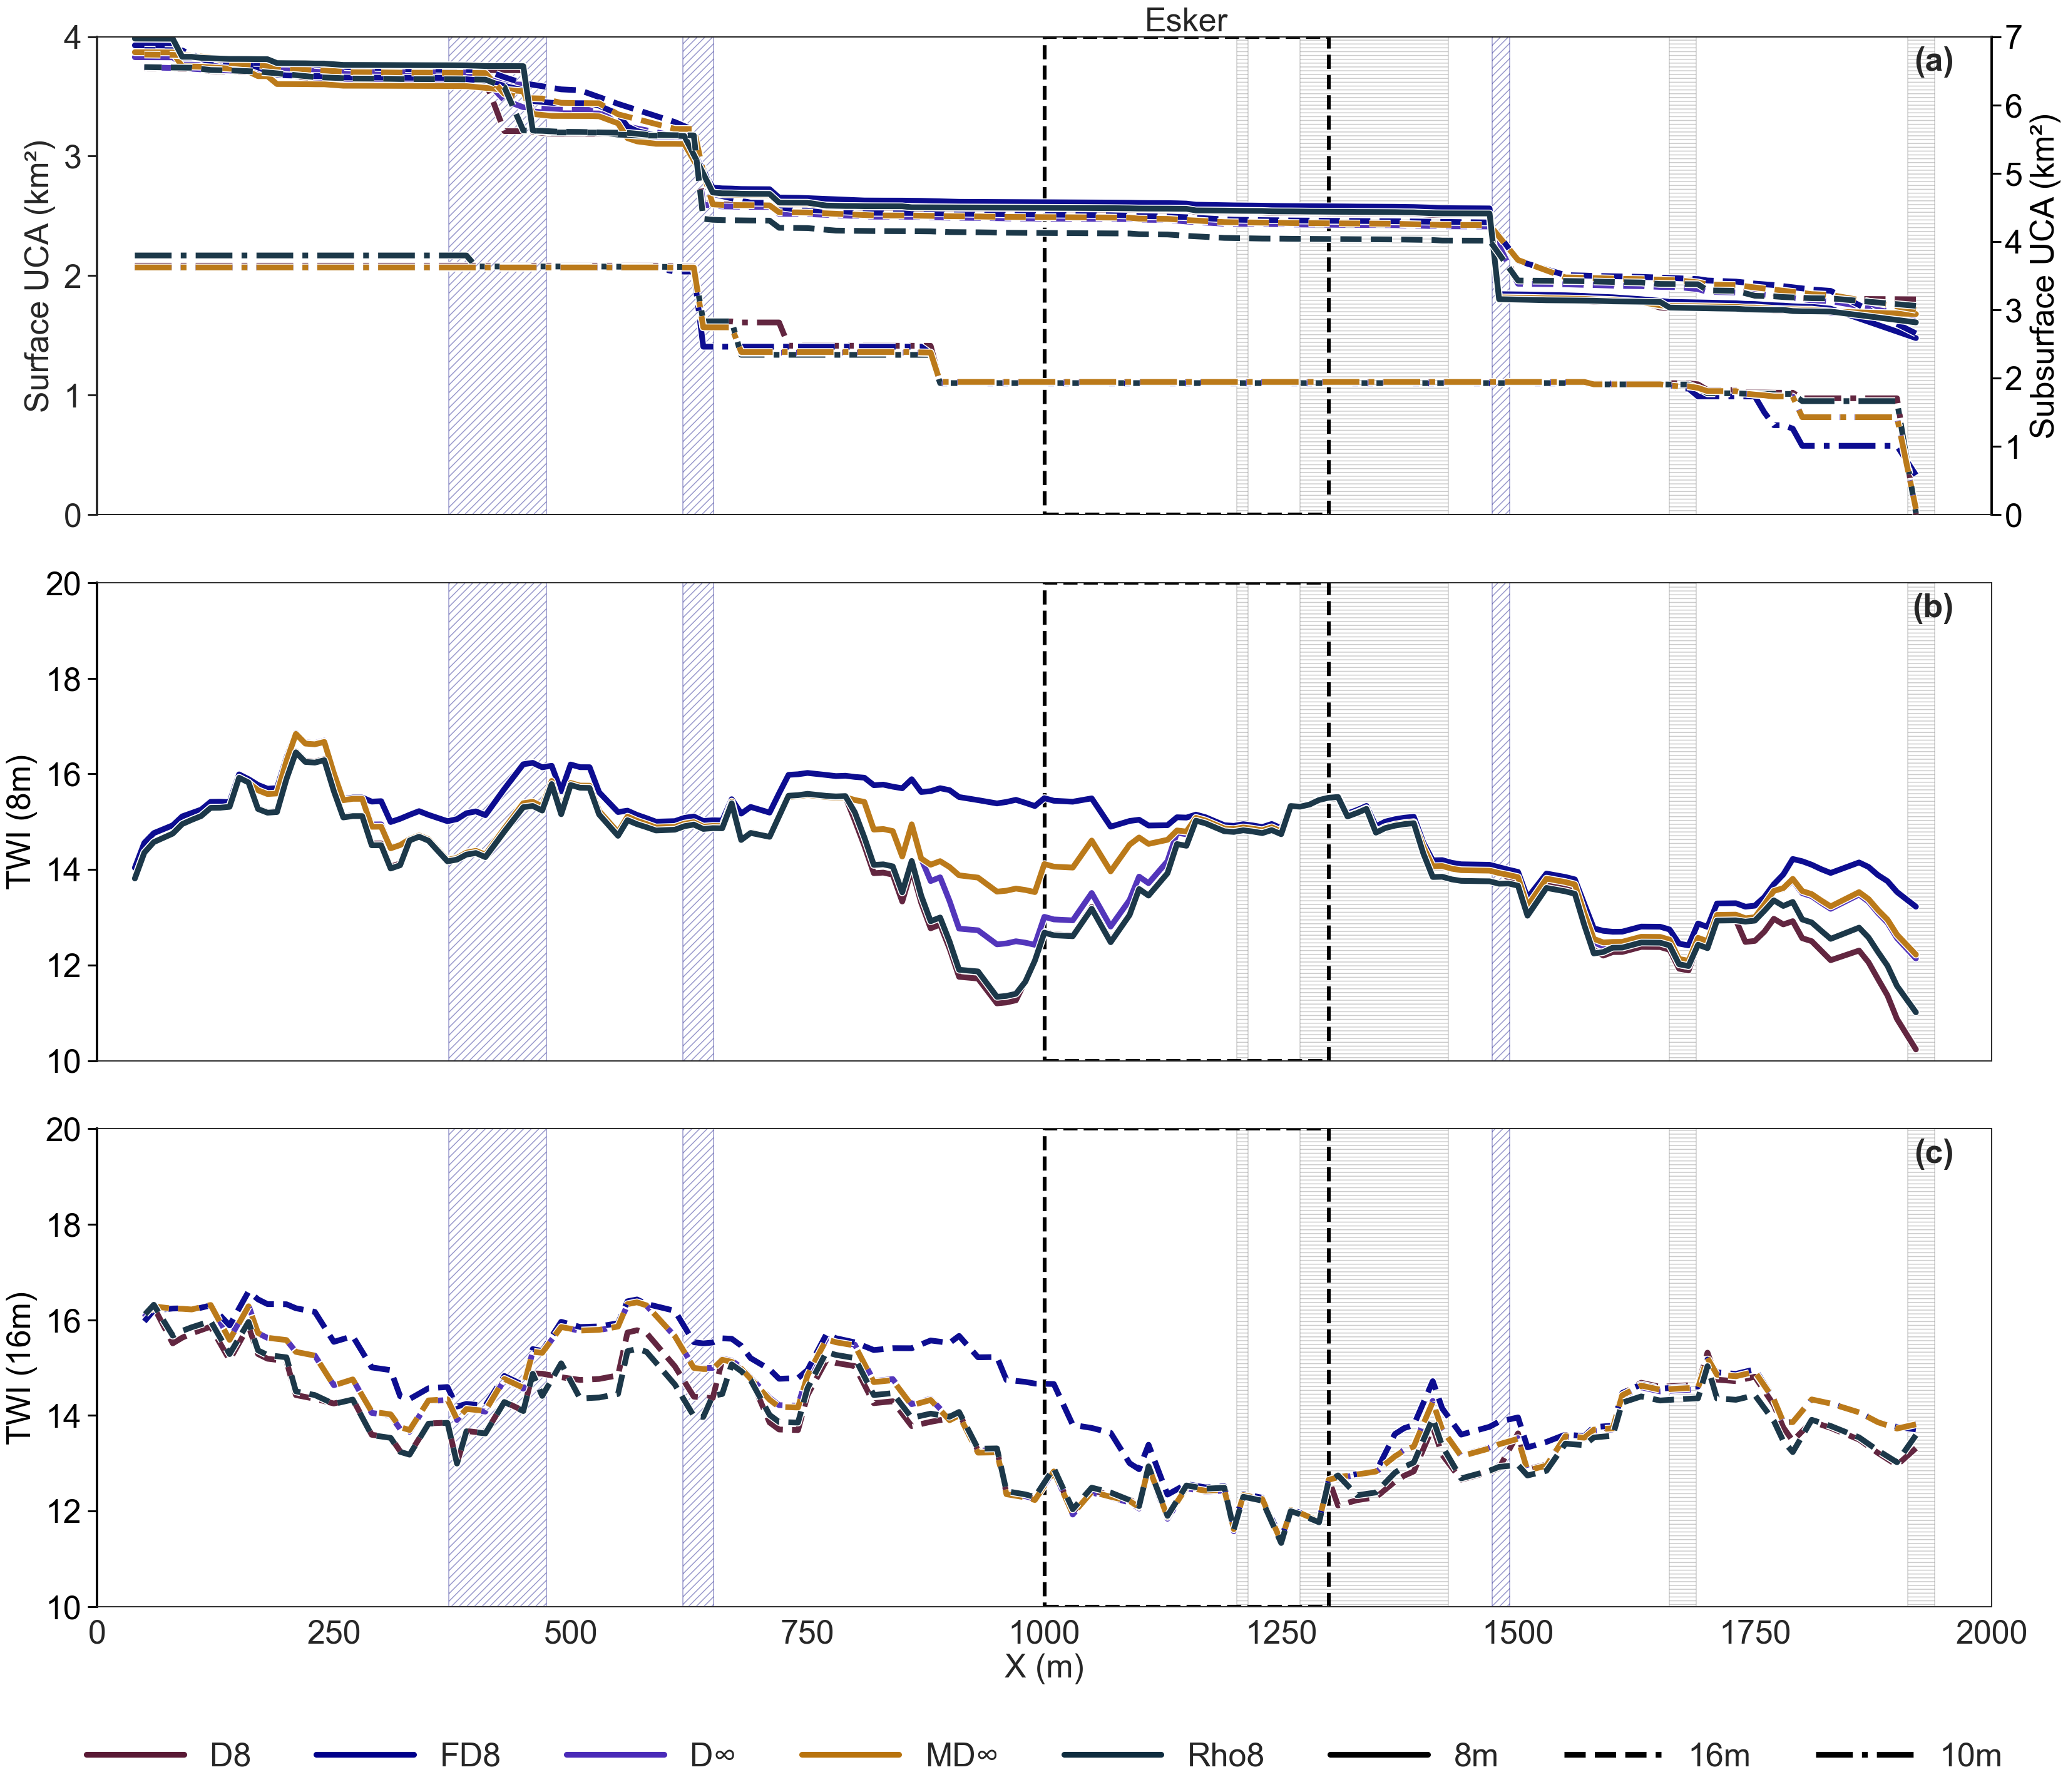

In [ ]:
# ============================================================
# NEW CELL: UCAs & TWI with GW/SW hatched zones + Esker region
# ============================================================

import os
import tempfile

import pandas as pd
import matplotlib.pyplot as plt


# --- Input CSVs exported from DTS GW & SW Classifications.ipynb ---
GW_SLOPE_CSV = "./GW_inflow_locations_slope.csv"
SW_SLOPE_CSV = "./SW_inflow_locations_slope.csv"


gw_zones = pd.read_csv(GW_SLOPE_CSV)
sw_zones = pd.read_csv(SW_SLOPE_CSV)


def _segments_from_df(df: pd.DataFrame):
    if {"x_start_m", "x_end_m"}.issubset(df.columns):
        return list(zip(df["x_start_m"].values, df["x_end_m"].values))
    if {"start_m", "end_m"}.issubset(df.columns):
        return list(zip(df["start_m"].values, df["end_m"].values))
    raise ValueError(
        "Could not find segment columns. Expected x_start_m/x_end_m or start_m/end_m. "
        f"Found: {list(df.columns)}"
    )


gw_segments_hatch = _segments_from_df(gw_zones)
sw_segments_hatch = _segments_from_df(sw_zones)


# --- Avoid the built-in light-grey GW shading inside the plot function ---
empty_gw_csv = os.path.join(tempfile.gettempdir(), "empty_gw_inflow_locations.csv")
pd.DataFrame({"start_m": [], "end_m": []}).to_csv(empty_gw_csv, index=False)


# --- Generate the same 3-panel plot (but without the built-in GW background) ---
fig_hatched, ax_all_hatched = plot_ucas_and_twi_all_methods_three_panels(
    surface_flow_data=surface_flow_data,
    bedrock_flow_profiles=bedrock_profiles,
    twi_data=twi_data,
    twi_method_colors=twi_method_colors,
    twi_resolution_styles=twi_resolution_styles,
    method_colors=method_colors,
    resolution_styles=resolution_styles,
    surface_flow_acc_ylim=(0, 4),
    bedrock_flow_acc_ylim=(0, 7),
    twi_8m_ylim=(10, 20),
    twi_16m_ylim=(10, 20),
    gw_inflow_path=empty_gw_csv,
    show=False,
)

ax_uca_h, ax_twi_8m_h, ax_twi_16m_h = ax_all_hatched[0], ax_all_hatched[1], ax_all_hatched[2]


def _axes_with_shared_x(ax):
    # Includes twinx() axes (bedrock axis), so the hatch appears there too.
    try:
        return list(ax.get_shared_x_axes().get_siblings(ax))
    except Exception:
        return [ax]


def _add_hatched_segments(ax, segments, *, edgecolor, hatch, alpha=0.4):
    """Add hatched background segments to axis."""
    for s, e in segments:
        ax.axvspan(s, e, facecolor="none", edgecolor=edgecolor, hatch=hatch, alpha=alpha, zorder=0)


def _add_esker(ax, *, start=1000, end=1300):
    """Add esker zone with dashed black border."""
    ax.axvspan(start, end, facecolor="none", edgecolor="black", linestyle="--", linewidth=4, zorder=1)


# Apply GW, SW and Esker overlays to all three panels.
# Important: draw the hatch only once per panel (otherwise twinx axes can double-draw the hatch).
for base_ax in [ax_uca_h, ax_twi_8m_h, ax_twi_16m_h]:
    siblings = _axes_with_shared_x(base_ax)

    # Make any twinned/overlaid axes transparent so base hatch shows through
    for ax in siblings:
        if ax is not base_ax:
            try:
                ax.patch.set_alpha(0)
            except Exception:
                pass

    # Draw hatch + esker on the base axis only
    _add_hatched_segments(base_ax, gw_segments_hatch, edgecolor="grey", hatch="---", alpha=0.4)
    _add_hatched_segments(base_ax, sw_segments_hatch, edgecolor="navy", hatch="///", alpha=0.4)
    _add_esker(base_ax, start=1000, end=1300)


# Keep ONLY panel labels (a), (b), (c) as free text on the plot
panel_axes = [ax_uca_h, ax_twi_8m_h, ax_twi_16m_h]
panel_labels = ['(a)', '(b)', '(c)']

# Remove any suptitle
try:
    if getattr(fig_hatched, "_suptitle", None) is not None:
        fig_hatched._suptitle.set_text("")
except Exception:
    pass

for ax, label in zip(panel_axes, panel_labels):
    # Remove axis title text (if any)
    try:
        ax.set_title("")
    except Exception:
        pass

    # Remove all annotation texts except the panel label
    found_label = False
    for t in list(ax.texts):
        txt = (t.get_text() or "").strip()
        if txt.startswith('(a)') or txt.startswith('(b)') or txt.startswith('(c)'):
            t.set_text(label)
            found_label = True
        else:
            try:
                t.remove()
            except Exception:
                pass

    # If the plotting function didn't add labels, add them now
    if not found_label:
        ax.text(
            0.01, 0.96,
            label,
            transform=ax.transAxes,
            ha='left', va='top',
            fontfamily='Arial',
            fontsize=34,
            zorder=10,
        )


# Add single esker label on top panel
esker_start = 1000
esker_end = 1300
ax_uca_h.text(
    0.5 * (esker_start + esker_end),
    ax_uca_h.get_ylim()[1],
    "Esker",
    ha="center",
    va="bottom",
    fontsize=34,
    rotation=0
)


plt.show()
